<a href="https://colab.research.google.com/github/MichaelJP-DS/Flight-Arrival-Classification-Models/blob/main/Flight_Arrival_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flight Arrival Classification Models

Working with different models to predict arrival times of flights from 2015

## Classes

1. More Than 10 Minutes Early
2. 10 Minutes Early to Exacly on Time
3. On Time and Up to 10 Minutes Late
4. More Than 10 Minutes Late

# Project Flow

Select Data Set

* Read in Data Set
* Set up wrangle function for cleaning and normalization
* Use Scikit-Learn to split data for training and validation
* Establish a Baseline
* Set up models
* Test Accuracy
* Utilize Hyperparameter Tuning
* Visualize Permutation Importances
* Use Confusion Matrix and other tools to visualize results


# Baseline

* Use value counts method to set baseline


# Considerations

* Data Leakage

It's possible the departure delay is potentially too much leakage.  I did trim out data where the delay was greater than 30 minutes.  This is a little Bayesian, but I expect departure delays are possible and flights are still on time.


* Model Uses



* Other Uses?

Feel free to DM me on LinkedIn and let me know other ways the model might be valuable.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [92]:
# Import Statements

# Libraries
import pandas as pd
import numpy as np

# Data Processing
from sklearn.preprocessing import minmax_scale
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# ML Boosted Model
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

# Neural Network/ML
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, softmax
from keras.layers import Dropout

# Viz & Analysis
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix, classification_report



In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
df_flights = pd.read_csv('/content/drive/MyDrive/Classification Data/flights.csv', low_memory=False)

In [ ]:
df_flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Wrangle Function for NN w/ data normalization

In [75]:
def wrangle_neuralN(df):

  # Eliminate columns that may result in data leakage
  df = df.drop(columns= ['WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 'ARRIVAL_TIME', 'YEAR', 'DAY'])

  # Drop rows when flight was cancelled but keep data when flight was not
  df = df.drop(df[df.CANCELLED == 1].index)

  df = df.drop(df[df.DIVERTED == 1].index)

  # Now drop cancelled column the resulting rows where not impacted by cancelled flight
  df = df.drop(columns= ['CANCELLED', 'CANCELLATION_REASON'])

  # Drop rows where the flight is delayed greater than 15 minutes - too leaky may tinker with this
  #df = df.drop(df[df.DEPARTURE_DELAY >= 15.0].index)

  # Drop rows related to reason for departure delay & high null value count.
  df = df.drop(columns= ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'AIRLINE_DELAY','DIVERTED', 'DEPARTURE_DELAY'])

  # Drop High Cardinality Column
  df = df.drop(columns= ['TAIL_NUMBER', 'FLIGHT_NUMBER'])

  # Label encode Airline, Origin Airport and Destination Airport
  enc = preprocessing.LabelEncoder()
  df['AIRLINE'] = enc.fit_transform(df['AIRLINE'])
  df['ORIGIN_AIRPORT'] = enc.fit_transform(df['ORIGIN_AIRPORT'])
  df['DESTINATION_AIRPORT'] = enc.fit_transform(df['DESTINATION_AIRPORT'])

  # Impute limited null values with column mean
  df['ARRIVAL_DELAY'] = df['ARRIVAL_DELAY'].fillna(4)
  df['TAXI_IN'] = df['TAXI_IN'].fillna(7.4)  

  # Set up target column in classes
  df.loc[df['ARRIVAL_DELAY'] <= -10.0, 'ARRIVAL' ] = 0
  df.loc[(df['ARRIVAL_DELAY'] > -10.0) & (df['ARRIVAL_DELAY'] <= 0.0), 'ARRIVAL'] = 1
  df.loc[(df['ARRIVAL_DELAY'] > 0), 'ARRIVAL'] = 2

  
  # Convert arrival to Integer for NN
  df['ARRIVAL'] = df['ARRIVAL'].astype(int)

  # Drop modified column
  df = df.drop(columns='ARRIVAL_DELAY')

  # Normalize data for processing

  df['MONTH'] = minmax_scale(df['MONTH'])      
  df['DAY_OF_WEEK'] = minmax_scale(df['DAY_OF_WEEK'])
  df['AIRLINE'] = minmax_scale(df['AIRLINE'])
  df['ORIGIN_AIRPORT'] = minmax_scale(df['ORIGIN_AIRPORT'])
  df['DESTINATION_AIRPORT'] = minmax_scale(df['DESTINATION_AIRPORT'])
  df['SCHEDULED_DEPARTURE'] = minmax_scale(df['SCHEDULED_DEPARTURE'])
  df['DEPARTURE_TIME'] = minmax_scale(df['DEPARTURE_TIME'])
  #df['DEPARTURE_DELAY'] = minmax_scale(df['DEPARTURE_DELAY'])  
  df['TAXI_OUT'] = minmax_scale(df['TAXI_OUT'])
  df['SCHEDULED_TIME'] = minmax_scale(df['SCHEDULED_TIME'])      
  df['DISTANCE'] = minmax_scale(df['DISTANCE'])            
  df['TAXI_IN'] = minmax_scale(df['TAXI_IN'])                
  df['SCHEDULED_ARRIVAL'] = minmax_scale(df['SCHEDULED_ARRIVAL'])
  df['ARRIVAL'] = minmax_scale(df['ARRIVAL']) 

  df = df.iloc[0:1000000]               

  return df

## Wrangle Function for XGBClassifier non-normalized data

In [73]:
def wrangle_XGBClass(df):

  # Eliminate columns that may result in data leakage
  df = df.drop(columns= ['WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 'ARRIVAL_TIME', 'YEAR', 'DAY'])

  # Drop rows when flight was cancelled but keep data when flight was not
  df = df.drop(df[df.CANCELLED == 1].index)

  df = df.drop(df[df.DIVERTED == 1].index)

  # Now drop cancelled column the resulting rows where not impacted by cancelled flight
  df = df.drop(columns= ['CANCELLED', 'CANCELLATION_REASON'])

  # Drop rows where the flight is delayed greater than 15 minutes - too leaky may tinker with this
  #df = df.drop(df[df.DEPARTURE_DELAY >= 15.0].index)

  # Drop rows related to reason for departure delay & high null value count.
  df = df.drop(columns= ['AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'AIRLINE_DELAY','DIVERTED', 'DEPARTURE_DELAY'])

  # Drop High Cardinality Column
  df = df.drop(columns= ['TAIL_NUMBER', 'FLIGHT_NUMBER'])

  # Label encode Airline, Origin Airport and Destination Airport
  enc = preprocessing.LabelEncoder()
  df['AIRLINE'] = enc.fit_transform(df['AIRLINE'])
  df['ORIGIN_AIRPORT'] = enc.fit_transform(df['ORIGIN_AIRPORT'])
  df['DESTINATION_AIRPORT'] = enc.fit_transform(df['DESTINATION_AIRPORT'])

  # Impute limited null values with column mean
  df['ARRIVAL_DELAY'] = df['ARRIVAL_DELAY'].fillna(4)
  df['TAXI_IN'] = df['TAXI_IN'].fillna(7.4)  

  # Set up target column in classes
  df.loc[df['ARRIVAL_DELAY'] <= -10.0, 'ARRIVAL' ] = 0
  df.loc[(df['ARRIVAL_DELAY'] > -10.0) & (df['ARRIVAL_DELAY'] <= 0.0), 'ARRIVAL'] = 1
  df.loc[(df['ARRIVAL_DELAY'] > 0), 'ARRIVAL'] = 2

  
  # Convert arrival to Integer for NN
  df['ARRIVAL'] = df['ARRIVAL'].astype(int)

  # Drop modified column
  df = df.drop(columns='ARRIVAL_DELAY')

  df = df.iloc[0:1000000]               

  return df

## Run dataframe wrangle function

In [76]:
df_Neural_Net = wrangle_neuralN(df_flights)

In [77]:
df_Classifier = wrangle_XGBClass(df_flights)

## Quick Check for Null Values

In [78]:
df_Neural_Net.isnull().sum()

MONTH                  0
DAY_OF_WEEK            0
AIRLINE                0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
TAXI_OUT               0
SCHEDULED_TIME         0
DISTANCE               0
TAXI_IN                0
SCHEDULED_ARRIVAL      0
ARRIVAL                0
dtype: int64

In [79]:
df_Classifier.isnull().sum()

MONTH                  0
DAY_OF_WEEK            0
AIRLINE                0
ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
TAXI_OUT               0
SCHEDULED_TIME         0
DISTANCE               0
TAXI_IN                0
SCHEDULED_ARRIVAL      0
ARRIVAL                0
dtype: int64

## Train, Test, Split NN

In [80]:
y = df_Neural_Net['ARRIVAL']

X = df_Neural_Net.drop(columns='ARRIVAL')

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train Test Split Classifier

In [82]:
y_C = df_Classifier['ARRIVAL']

X_C = df_Classifier.drop(columns='ARRIVAL')

In [83]:
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C, test_size=0.2)

## Model Baseline

In [88]:
BaseLine = y_train.value_counts(normalize=True).max()

print('Simple Baseline', BaseLine)

Simple Baseline 0.4222375


## Gradient Boosting Classifier

In [85]:
gbc_model = make_pipeline(
    XGBClassifier(n_estimators=5)
)

gbc_model.fit(X_train_C, y_train_C)

Pipeline(steps=[('xgbclassifier',
                 XGBClassifier(n_estimators=5, objective='multi:softprob'))])

## Build Fully Connected Neural Network
Use early stopping and dropout
Use Relu activation function
Use softmax for output
multiclass crossentropy for loss function

In [86]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model = Sequential()
model.add(Dense(100, input_dim=12, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='Adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [87]:
model.fit(X_train, y_train, 
          validation_data=(X_test, y_test),
          workers=-1, 
          epochs=2, 
          batch_size=16, 
          verbose=1,
          shuffle=True,
          callbacks=[callback])

Epoch 1/2
50000/50000 [==============================] - 132s 3ms/step - loss: 0.4699 - accuracy: 0.5597 - val_loss: 0.3792 - val_accuracy: 0.6073
Epoch 2/2
50000/50000 [==============================] - 118s 2ms/step - loss: 0.4239 - accuracy: 0.5870 - val_loss: 0.3675 - val_accuracy: 0.6029


## Check XGB Score

* XGBoost

In [89]:
print('Test Score', accuracy_score(y_train_C, gbc_model.predict(X_train_C)))
print('Val Score', accuracy_score(y_test_C, gbc_model.predict(X_test_C)))

Test Score 0.50624375
Val Score 0.50745


# Hyperparameter Tuning
* XGBoost
* RNN Network

### GBC

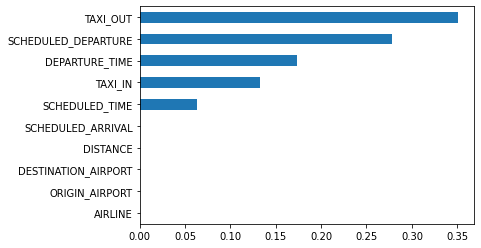

In [90]:
importances = gbc_model.named_steps.xgbclassifier.feature_importances_
features = X_train_C.columns
pd.Series(importances, index=features).sort_values().tail(10).plot(kind='barh');

### GBC CM

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


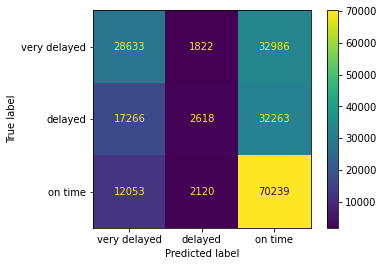

In [95]:
GBC = plot_confusion_matrix(
    gbc_model,
    X_test_C,
    y_test_C,
    values_format = '.0f',
    display_labels = ['very delayed', 'delayed', 'on time']

);